In [1]:
%matplotlib notebook

In [2]:
from firedrake import *
from contexttimer import Timer
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [4]:
PETSc.Sys.popErrorHandler()

In [5]:
p = 1
family = "CG"
resolutions = [8, 16, 32, 64, 128, 256]

In [6]:
def kernel(V):
    x, y = SpatialCoordinate(V.mesh())
    return x*y*(x-1)*(y-1)

In [7]:
# sp = {
#     "mat_type": "aij",
#     "ksp_type": "preonly",
#     "pc_type": "lu",
#     "pc_factor_mat_solver_type": "mumps",
# }
sp = {
    "ksp_type": "cg",
    "pc_type": "none",
}
sp_mass_inv = {
    "mat_type": "matfree",
    "ksp_type": "preonly",
    "pc_type": "python",
    "pc_python_type": "firedrake.MassInvPC",
}
sp_ibp = {
    "ksp_type": "gmres",
    "ksp_gmres_restart": 20,
    "ksp_rtol": 1.0e-05,
    "pc_type": "sor",
}
# sp_patch = {
#     "mat_type": "matfree",
#     "ksp_type": "preonly",
#     "pc_type": "python",
#     "pc_python_type": "firedrake.PatchPC",
#     "patch_pc": {
#         "patch_construct_type": "vanka",
#         "patch_construct_codim": 0,
#         "patch_save_operators": False,
#     },
#     "patch_sub": {
#         "ksp_type": "preonly",
#         "pc_type": "lu",
#     },
# }

In [8]:
def solve_forward(V, solver_parameters=sp):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    x, y = SpatialCoordinate(V.mesh())
    f = 2*pi*pi*sin(pi*x)*sin(pi*y)
    
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=solver_parameters)
    return uh

In [9]:
def solve_adjoint(V):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    f = kernel(V)
    
    a = inner(grad(u), grad(v))*dx
    L = inner(grad(f), grad(v))*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=sp)
    return uh

In [10]:
def exact_solution(V):
    x, y = SpatialCoordinate(V.mesh())
    return sin(pi*x)*sin(pi*y)

In [11]:
def qoi(u, V=None):
    V = V or u.function_space()
    return assemble(inner(grad(u), grad(kernel(V)))*dx(domain=V.mesh()))

In [12]:
qoi_exact = 32/pi**4

In [13]:
dofs = []
L2_errors = []
H1_errors = []
qois = []
qoi_errors = []
print("DoFs    L2 error    H1 error    QoI error")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    Vc = FunctionSpace(mesh, family, p)
    uc = solve_forward(Vc)
    uc_exact = exact_solution(Vc)
    
    dof = Vc.dof_count
    Ju = qoi(uc, Vc)
    Je = abs(qoi_exact - Ju)/qoi_exact
    L2_error = errornorm(uc_exact, uc)/norm(uc_exact)
    H1_error = errornorm(uc_exact, uc, norm_type='H1')/norm(uc_exact, norm_type='H1')
    
    print(f"{dof:6d}  {L2_error:.4e}  {H1_error:.4e}  {Je:.4e}")
    dofs.append(dof)
    L2_errors.append(L2_error)
    H1_errors.append(H1_error)
    qois.append(Ju)
    qoi_errors.append(Je)

DoFs    L2 error    H1 error    QoI error
    81  4.2266e-02  1.8986e-01  3.7932e-02
   289  1.0755e-02  9.5565e-02  9.5992e-03
  1089  2.7009e-03  4.7863e-02  2.4071e-03
  4225  6.7598e-04  2.3941e-02  6.0224e-04
 16641  1.6904e-04  1.1972e-02  1.5059e-04
 66049  4.2264e-05  5.9861e-03  3.7649e-05


<IPython.core.display.Javascript object>


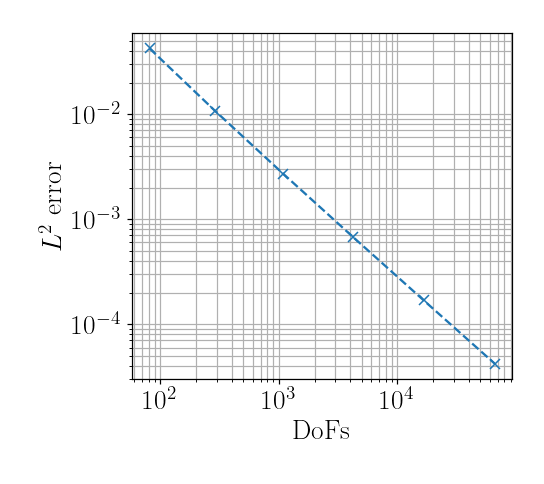

<IPython.core.display.Javascript object>


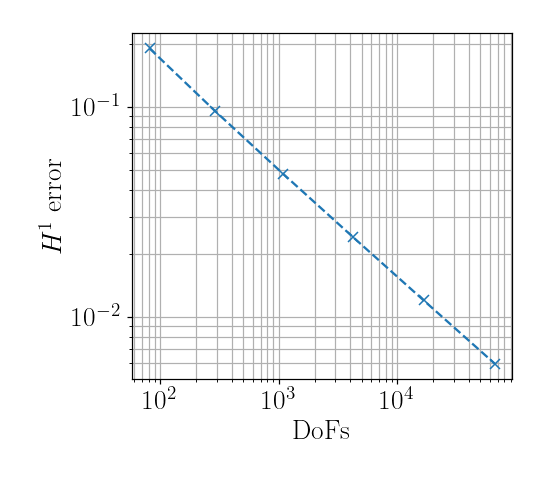

<IPython.core.display.Javascript object>


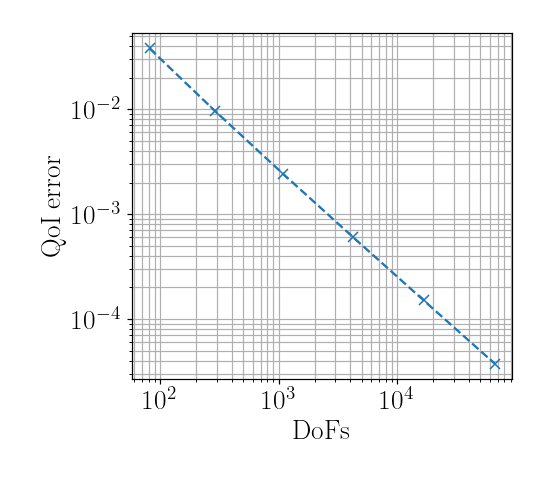

In [14]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, L2_errors, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel(r"$L^2$ error")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig("l2_error.pdf")

fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, H1_errors, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel(r"$H^1$ error")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig("H1_error.pdf")

fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, qoi_errors, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel("QoI error")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig("qoi_error.pdf")

In [15]:
def indicate_GEp(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    Vf = FunctionSpace(mesh, family, p+1)
    uf = solve_forward(Vf)
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = -p0test*dot(grad(kernel(Vc) - uc_adj), n)*(uf - uc)
    i_GEp = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, i_GEp, solver_parameters=sp_mass_inv)
    i_GEp += assemble(p0test*div(grad(kernel(Vc) - uc_adj))*(uf - uc)*dx)
    return i_GEp

In [16]:
def indicate_GEh(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    x, y = SpatialCoordinate(mesh)
    Vf = FunctionSpace(mh[1], family, p)
    uf = solve_forward(Vf)
    uc_prolong = Function(Vf)
    uc_adj_prolong = Function(Vf)
    prolong(uc, uc_prolong)
    prolong(uc_adj, uc_adj_prolong)
    x_prolong = Function(Vf)
    y_prolong = Function(Vf)
    prolong(interpolate(x, Vc), x_prolong)
    prolong(interpolate(y, Vc), y_prolong)
    k_prolong = x_prolong*(x_prolong-1)*y_prolong*(y_prolong-1)
    P0 = FunctionSpace(mh[1], "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mh[1])
    loc = -p0test*dot(grad(k_prolong - uc_adj_prolong), n)*(uf - uc_prolong)
    _i_GEh = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, _i_GEh, solver_parameters=sp_mass_inv)
    _i_GEh += assemble(p0test*div(grad(k_prolong - uc_adj_prolong))*(uf - uc_prolong)*dx)
    i_GEh = Function(FunctionSpace(mesh, "DG", 0))
    i_GEh.project(_i_GEh)
    i_GEh *= 4  # Four times fewer cells
    return i_GEh

In [17]:
# def indicate_LEh(uc, uc_adj, niter=3):
#     Vc = uc.function_space()
#     mesh = Vc.mesh()
#     x, y = SpatialCoordinate(mesh)
#     Vf = FunctionSpace(mh[1], family, p)
#     v = TestFunction(Vf)
#     uc_prolong = Function(Vf)
#     uc_adj_prolong = Function(Vf)
#     prolong(uc, uc_prolong)
#     prolong(uc_adj, uc_adj_prolong)
    
#     a = inner(grad(TrialFunction(Vf)), grad(v))*dx
#     for i in range(niter):
#         e = Function(Vf)
#         L = inner(grad(kernel(Vf)), grad(v))*dx - inner(grad(uc_prolong), grad(v))*dx
#         solve(a == L, e, bcs=DirichletBC(Vf, 0, 'on_boundary'), solver_parameters=sp_patch)
#         uc_prolong = uc_prolong + e
    
#     x_prolong = Function(Vf)
#     y_prolong = Function(Vf)
#     prolong(interpolate(x, Vc), x_prolong)
#     prolong(interpolate(y, Vc), y_prolong)
#     k_prolong = x_prolong*(x_prolong-1)*y_prolong*(y_prolong-1)
#     P0 = FunctionSpace(mh[1], "DG", 0)
#     p0test = TestFunction(P0)
#     n = FacetNormal(mh[1])
#     loc = -p0test*dot(grad(k_prolong - uc_adj_prolong), n)*e
#     _i_LEh = Function(P0)
#     solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, _i_LEh, solver_parameters=sp_mass_inv)
#     _i_LEh += assemble(p0test*div(grad(k_prolong - uc_adj_prolong))*e*dx)
#     i_LEh = Function(FunctionSpace(mesh, "DG", 0))
#     i_LEh.project(_i_LEh)
#     i_LEh *= 4  # Four times fewer cells
#     return i_LEh

In [18]:
# def indicate_LEp(uc, uc_adj, niter=3):
#     Vc = uc.function_space()
#     mesh = Vc.mesh()
#     Vf = FunctionSpace(mesh, family, p+1)
#     v = TestFunction(Vf)
    
#     a = inner(grad(TrialFunction(Vf)), grad(v))*dx
#     for i in range(niter):
#         e = Function(Vf)
#         L = inner(grad(kernel(Vf)), grad(v))*dx - inner(grad(uc), grad(v))*dx
#         solve(a == L, e, bcs=DirichletBC(Vf, 0, 'on_boundary'), solver_parameters=sp_patch)
#         uc = uc + e
    
#     P0 = FunctionSpace(mesh, "DG", 0)
#     p0test = TestFunction(P0)
#     n = FacetNormal(mesh)
#     loc = -p0test*dot(grad(kernel(Vc) - uc_adj), n)*e
#     _i_LEp = Function(P0)
#     solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, _i_LEp, solver_parameters=sp_mass_inv)
#     _i_LEp += assemble(p0test*div(grad(kernel(Vc) - uc_adj))*e*dx)
#     i_LEp = Function(FunctionSpace(mesh, "DG", 0))
#     i_LEp.project(_i_LEp)
#     return i_LEp

In [19]:
def indicate_DQ(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = p0test*dot(grad(kernel(Vc) - uc_adj), n)*dot(grad(kernel(Vc) - uc_adj), n)
    flux = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, flux, solver_parameters=sp_mass_inv)
    cell = assemble(p0test*div(grad(kernel(Vc) - uc_adj))*div(grad(kernel(Vc) - uc_adj))*dx)
    vP1 = VectorFunctionSpace(mesh, "CG", 1)
    g, psi = TrialFunction(vP1), TestFunction(vP1)
    a = inner(g, psi)*dx
    L = uc*dot(psi, n)*ds - uc*div(psi)*dx
    g = Function(vP1)
    solve(a == L, g, solver_parameters=sp_ibp)
    h = CellSize(mesh)
    return project(h**2*(sqrt(abs(cell)) + sqrt(abs(flux)/h))*sqrt(div(g)*div(g)), P0)

In [20]:
GEh, GEp, LEh, LEp, DQ = [], [], [], [], []
t_GEh, t_GEp, t_LEh, t_LEp, t_DQ = [], [], [], [], []
t_adj = []
print("DoFs    cells    GEp          GEh          DQ")
# print("DoFs    cells    GEp          GEh          LEh          LEp          DQ")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    x, y = SpatialCoordinate(mesh)
    mh = MeshHierarchy(mesh, 1)
    
    V = FunctionSpace(mesh, family, p)
    dof = V.dof_count
    u = solve_forward(V)
    with Timer() as t:
        u_adj = solve_adjoint(V)
    t_adj.append(t.elapsed)
    
    # GE_p
    with Timer() as t:
        i_GEp = indicate_GEp(u, u_adj)
        e_GEp = i_GEp.vector().gather().sum()
    GEp.append(e_GEp)
    t_GEp.append(t.elapsed)
    
    # GE_h
    with Timer() as t:
        i_GEh = indicate_GEh(u, u_adj)
        e_GEh = i_GEh.vector().gather().sum()
    GEh.append(e_GEh)
    t_GEh.append(t.elapsed)
    
#     # LE_h
#     with Timer() as t:
#         i_LEh = indicate_LEh(u, u_adj)
#         e_LEh = i_LEh.vector().gather().sum()
#     LEh.append(e_LEh)
#     t_LEh.append(t.elapsed)

#     # LE_p
#     with Timer() as t:
#         i_LEp = indicate_LEp(u, u_adj)
#         e_LEp = i_LEp.vector().gather().sum()
#     LEp.append(e_LEp)
#     t_LEp.append(t.elapsed)
    
    # DQ
    with Timer() as t:
        i_DQ = indicate_DQ(u, u_adj)
        e_DQ = i_DQ.vector().gather().sum()
    DQ.append(e_DQ)
    t_DQ.append(t.elapsed)
    
    print(f"{dof:6d}  {mesh.num_cells():6d}   {e_GEp:.4e}  {e_GEh:.4e}  {e_DQ:.4e}")
#     print(f"{dof:6d}  {mesh.num_cells():6d}   {e_GEp:.4e}  {e_GEh:.4e}  {e_LEh:.4e}  {e_LEp:.4e}  {e_DQ:.4e}")

DoFs    cells    GEp          GEh          DQ
    81     128   -1.2402e-02  -9.3078e-03  1.7563e+01
   289     512   -3.1497e-03  -2.3627e-03  1.5940e+01
  1089    2048   -7.9053e-04  -5.9292e-04  1.4959e+01
  4225    8192   -1.9782e-04  -1.4837e-04  1.4345e+01
 16641   32768   -4.9471e-05  -3.7105e-05  1.3982e+01
 66049  131072   -1.2382e-05  -9.2917e-06  1.3777e+01


In [21]:
qois = np.array(qois)
qoi_errors = np.array(qoi_errors)
t_adj = np.array(t_adj)
GEp = np.array(GEp)
GEh = np.array(GEh)
# LEh = np.array(LEh)
# LEp = np.array(LEp)
DQ = np.array(DQ)
Ieff_GEp = abs(GEp/qois/qoi_errors)
Ieff_GEh = abs(GEh/qois/qoi_errors)
# Ieff_LEh = abs(LEh/qois/qoi_errors)
# Ieff_LEp = abs(LEp/qois/qoi_errors)
Ieff_DQ = abs(DQ/qois/qoi_errors)
tn_GEp = t_GEp/t_adj
tn_GEh = t_GEh/t_adj
# tn_LEh = t_LEh/t_adj
# tn_LEp = t_LEp/t_adj
tn_DQ = t_DQ/t_adj

<IPython.core.display.Javascript object>


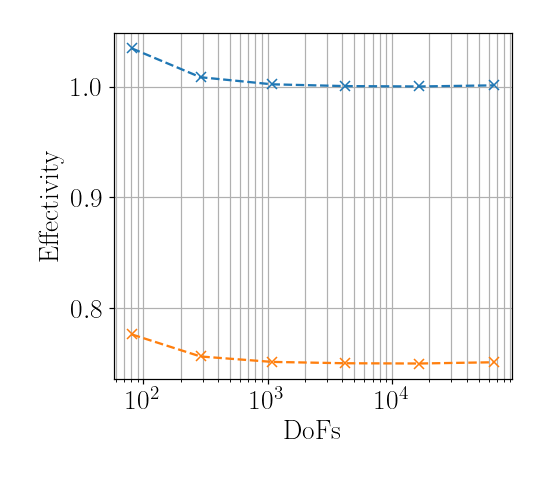

<IPython.core.display.Javascript object>


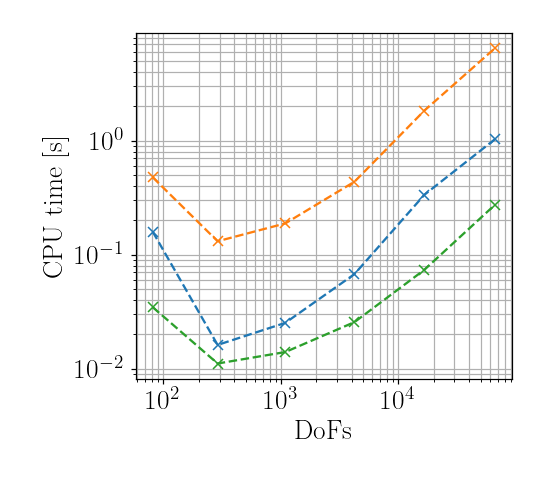

<IPython.core.display.Javascript object>


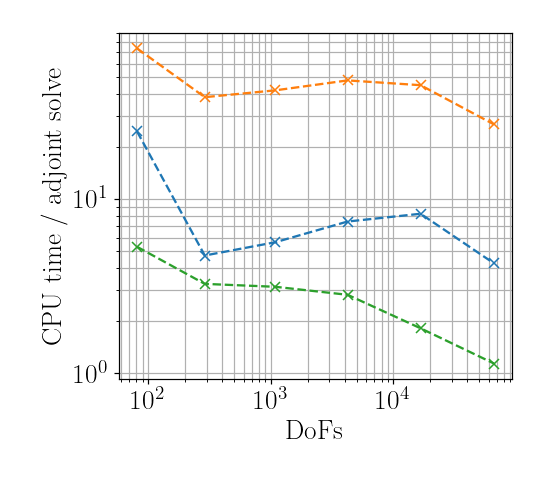

<IPython.core.display.Javascript object>


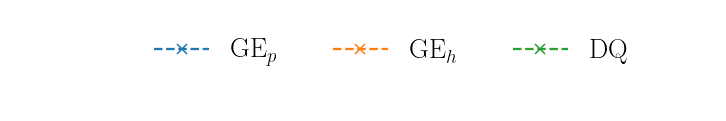

In [22]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.semilogx(dofs, Ieff_GEp, '--x')
axes.semilogx(dofs, Ieff_GEh, '--x')
# axes.semilogx(dofs, Ieff_LEh, '--x')
# axes.semilogx(dofs, Ieff_LEp, '--x')
# axes.semilogx(dofs, Ieff_DQ, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel("Effectivity")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig('effectivity.pdf')

fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, t_GEp, '--x', label=r'GE$_p$')
axes.loglog(dofs, t_GEh, '--x', label=r'GE$_h$')
# axes.loglog(dofs, t_LEh, '--x', label=r'LE$_h$')
# axes.loglog(dofs, t_LEp, '--x', label=r'LE$_p$')
axes.loglog(dofs, t_DQ, '--x', label='DQ')
axes.set_xlabel("DoFs")
axes.set_ylabel("CPU time [s]")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig('time.pdf')

fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, tn_GEp, '--x', label=r'GE$_p$')
axes.loglog(dofs, tn_GEh, '--x', label=r'GE$_h$')
# axes.loglog(dofs, tn_LEh, '--x', label=r'LE$_h$')
# axes.loglog(dofs, tn_LEp, '--x', label=r'LE$_p$')
axes.loglog(dofs, tn_DQ, '--x', label='DQ')
axes.set_xlabel("DoFs")
axes.set_ylabel("CPU time / adjoint solve")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig('relative_time.pdf')

fig2, axes2 = plt.subplots(figsize=(6, 1))
lines, labels = axes.get_legend_handles_labels()
legend = axes2.legend(lines, labels, fontsize=18, frameon=False, ncol=3)
fig2.canvas.draw()
axes2.set_axis_off()
bbox = legend.get_window_extent().transformed(fig2.dpi_scale_trans.inverted())
plt.savefig('legend.pdf')

In [23]:
i_GEp.interpolate(abs(i_GEp))
i_GEh.interpolate(abs(i_GEh))
i_DQ.interpolate(abs(i_DQ));

<IPython.core.display.Javascript object>


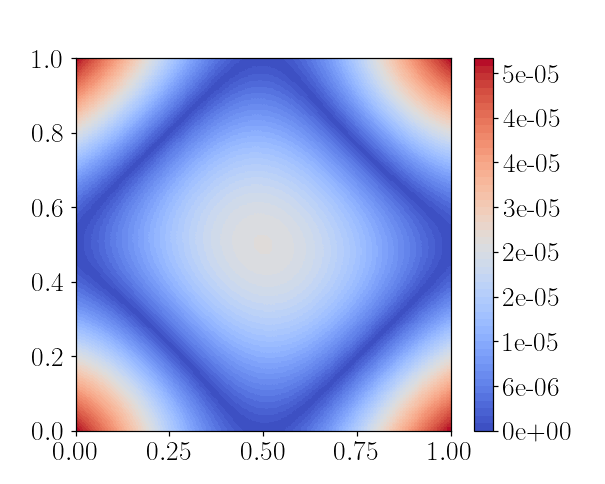

<IPython.core.display.Javascript object>


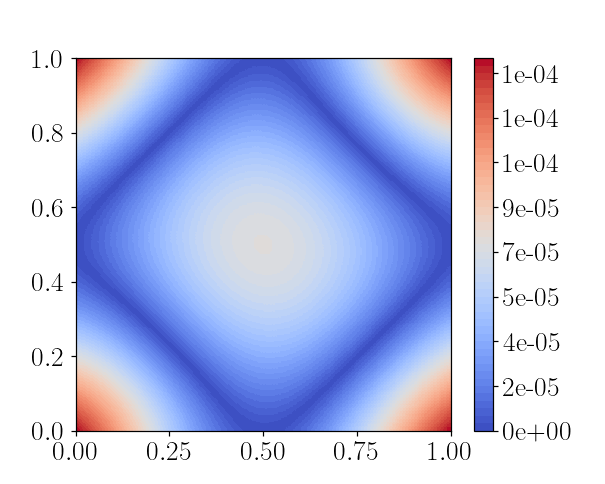

<IPython.core.display.Javascript object>


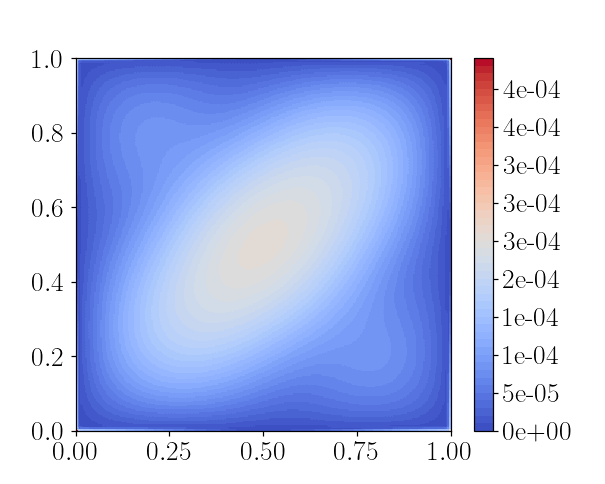

In [24]:
levels = 50
cmap = 'coolwarm'

fig, axes = plt.subplots(figsize=(5, 4))
cb = plt.colorbar(tricontourf(i_GEp, axes=axes, cmap=cmap, levels=levels), ax=axes, format='%.0e')
plt.savefig('indicator_GEh.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
cb = plt.colorbar(tricontourf(i_GEh, axes=axes, cmap=cmap, levels=levels), ax=axes, format='%.0e')
plt.savefig('indicator_GEp.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
cb = plt.colorbar(tricontourf(i_DQ, axes=axes, cmap=cmap, levels=levels), ax=axes, format='%.0e')
plt.savefig('indicator_DQ.jpg')